<a href="https://colab.research.google.com/github/aziegert/classification_alien_vs_predator/blob/main/classification_alien_vs_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
#basic
from google.colab import files
import os
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import PIL
from PIL import Image

#modeling
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import copy

%matplotlib inline

#Data loading

In [ ]:
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

 99% 14.0M/14.1M [00:00<00:00, 22.7MB/s]
100% 14.1M/14.1M [00:00<00:00, 14.9MB/s]


In [ ]:
!unzip /content/alien-vs-predator-images.zip

In [6]:
input_path = '/content/alien_vs_predator_thumbnails/data/'

train_path = os.path.join(input_path, 'train')
val_path = os.path.join(input_path, 'val')
test_path = os.path.join(input_path, 'validation')

#EDA

##Data review

In [ ]:
def rand_image(dataset):

  if dataset == 'test':
    img_path = test_path
  else:
    img_path = train_path

  n_label = random.randint(0,1)
  label = 'alien' if n_label == 0 else 'predator'
  files_list = os.listdir(os.path.join(img_path, label))
  idx = random.randint(1, len(files_list))
  img_path = os.path.join(img_path, label, files_list[idx])

  return Image.open(img_path), label

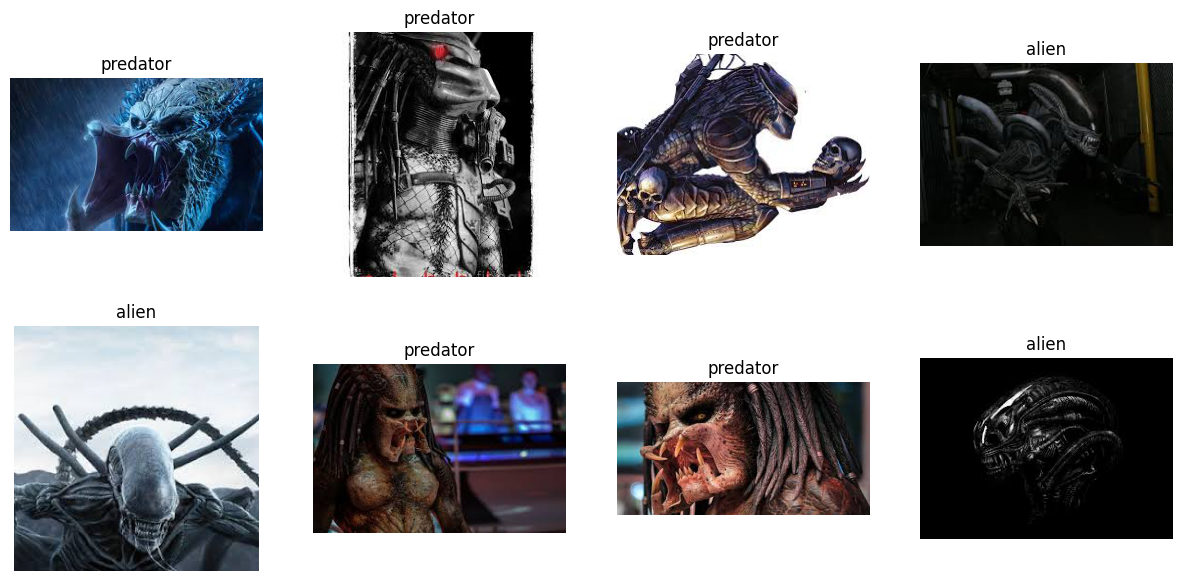

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

for i, ax in enumerate(axs.flatten()):
  img, label = rand_image('train')

  ax.axis('off')
  ax.imshow(img)
  ax.set_title(label)

##Split into train and validation sets

In [ ]:
os.makedirs(val_path, exist_ok=True)

random.seed(6)

for subdir in ['alien', 'predator']:
  os.makedirs(os.path.join(val_path, subdir), exist_ok=True)
  files_list = os.listdir(os.path.join(train_path, subdir))
  n_val_img = int(0.3*len(files_list))
  val_index = random.sample(range(len(files_list)), n_val_img)

  for idx, file_name in enumerate(files_list):
    if idx in val_index:
      img_path = os.path.join(train_path, subdir, file_name)
      dir_path = val_path if idx in val_index else train_path
      subdir_path = os.path.join(dir_path, subdir)
      shutil.move(img_path, subdir_path)

##Sample tranformations

In [7]:
compose = transforms.Compose([
                       transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                       transforms.RandomEqualize(),
                       transforms.RandomHorizontalFlip(),
                       transforms.RandomRotation(degrees=(0, 180)),
                       transforms.RandomCrop(size=(160, 160)),
                       transforms.RandomInvert()
                ])

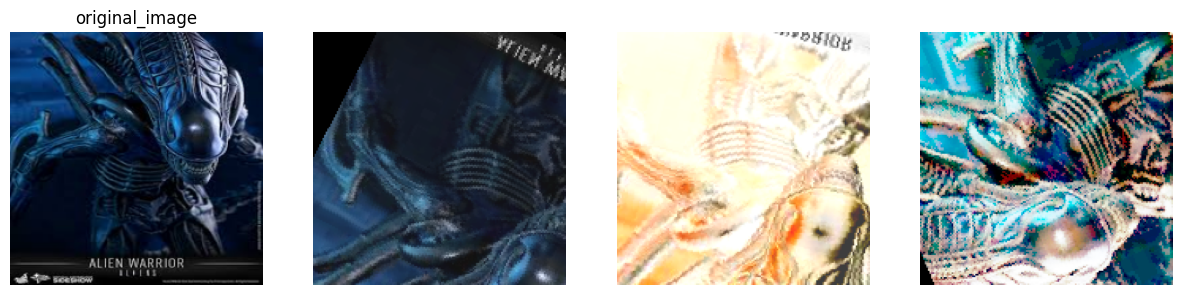

In [9]:
img_path = '/content/data/train/alien/111.jpg'
orig_img = Image.open(img_path)
orig_img = orig_img.resize((224,224), PIL.Image.BILINEAR)
compose_imgs = [compose(orig_img) for _ in range(4)]

fig, axs = plt.subplots(1, len(compose_imgs), figsize=(15, 7))
for i, img in enumerate(compose_imgs):
    axs[0].imshow(orig_img)
    axs[0].set_title('original_image')
    ax = axs[i]
    ax.axis('off')
    ax.imshow(img)

#Model

##Create Pytorch Data Generators

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def create_dataloaders(*args):
  data_transforms = {
      'train':
      transforms.Compose([
          transforms.Resize((224,224)),
          *args,
          transforms.ToTensor(),
          normalize
          ]),
      'val':
      transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          normalize
          ]),
      'test':
      transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          normalize
          ])
  }

  image_datasets = {
      'train':
      datasets.ImageFolder(train_path, data_transforms['train']),
      'val':
      datasets.ImageFolder(val_path, data_transforms['val']),
      'test':
      datasets.ImageFolder(test_path, data_transforms['test'])
  }

  dataloaders = {
      'train':
      torch.utils.data.DataLoader(image_datasets['train'],
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=1),
      'val':
      torch.utils.data.DataLoader(image_datasets['val'],
                                  batch_size=32,
                                  shuffle=False,
                                  num_workers=1),
      'test':
      torch.utils.data.DataLoader(image_datasets['test'],
                                  batch_size=32,
                                  shuffle=False,
                                  num_workers=1)
  }
  return dataloaders

##Create the network

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

x = torch.tensor([1., 2.]).to(device)

print(x)

tensor([1., 2.], device='cuda:0')


In [ ]:
model = models.resnet101(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

##Train model function

In [ ]:
def train_model(dataloaders, model, criterion, optimizer, num_epochs=3):

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_train_accuracy = 0
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                metrics[phase] = {}
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += sum(preds == labels.data)

            num_inputs = len(dataloaders[phase].dataset)
            metrics[phase]['loss'] = round(running_loss / num_inputs, 4)
            metrics[phase]['acc'] = round(running_corrects.item() / num_inputs, 4)

            print(f'{phase} loss: {metrics[phase]["loss"]:.4f}, {phase} accuracy: {metrics[phase]["acc"]:.4f}')

        if (metrics['val']['acc'] >= best_val_accuracy) and (metrics['train']['acc'] >= best_train_accuracy):
          best_val_accuracy = metrics['val']['acc']
          best_train_accuracy = metrics['train']['acc']
          best_metrics = pd.DataFrame(metrics)
          best_model = model

        train_loss_history.append(metrics['train']['loss'])
        train_accuracy_history.append(metrics['train']['acc'])
        val_loss_history.append(metrics['val']['loss'])
        val_accuracy_history.append(metrics['val']['acc'])

        train_history = [train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history]

    return best_model, best_metrics, train_history

In [ ]:
def test_model(dataloader, model, criterion):

  running_loss = 0.0
  running_corrects = 0

  model.eval()

  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += sum(preds == labels.data)

    num_inputs = len(dataloader.dataset)
    test_loss = running_loss / num_inputs
    test_accuracy = running_corrects.item() / num_inputs

  return test_loss, test_accuracy

In [ ]:
def plot_learning(train_history):
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  history = {'Accuracy': [train_history[0], train_history[1]], 'Loss': [train_history[2], train_history[3]]}

  for i, name in enumerate(['Accuracy', 'Loss']):
    ax = axs[i]
    ax.plot(history[name][0], label='train')
    ax.plot(history[name][1], label='validation')
    ax.set_title(name)
    ax.legend()
    ax.set_xlabel('no. of epochs')
  plt.show()

##Selecting transformations

In [ ]:
transformations = {
    'ColorJitter': transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    'RandomInvert': transforms.RandomInvert(),
    'RandomAutocontrast': transforms.RandomAutocontrast(),
    'RandomEqualize': transforms.RandomEqualize(),
    'RandomHorizontalFlip': transforms.RandomHorizontalFlip(),
    'RandomRotation': transforms.RandomRotation(degrees=(0, 180)),
    'RandomCrop': transforms.RandomCrop(size=(160, 160))
    }

In [ ]:
def check_transfrom(transformations):
  i = 0
  valid_scores = pd.DataFrame({'transformations': transformations.keys(), 'Validation accuracy': np.zeros(len(transformations))})

  for key, transform in transformations.items():
    print(key)
    dataloaders = create_dataloaders(transform)
    trained_model, metrics, history = train_model(dataloaders, model, criterion, optimizer, num_epochs=40)
    print()

    valid_scores.iloc[i,1] = metrics.iloc[1,1]

    i+=1
  return valid_scores

In [ ]:
valid_scores = check_transfrom(transformations)

In [ ]:
valid_scores

,transformations,Validation accuracy
0,ColorJitter,0.9710
1,RandomInvert,0.9855
2,RandomAutocontrast,0.9783
3,RandomEqualize,0.9855
4,RandomHorizontalFlip,0.9710
5,RandomRotation,0.9565
6,RandomCrop,0.9783


##Training model

###Few_transformations

In [ ]:
few_transformations = [transforms.RandomInvert(),
                       transforms.RandomAutocontrast(),
                       transforms.RandomEqualize()]

In [ ]:
dataloaders_few = create_dataloaders(*few_transformations)

Epoch 1/600
train loss: 0.6468, train accuracy: 0.6399
val loss: 0.5583, val accuracy: 0.8654
Epoch 2/600
train loss: 0.5454, train accuracy: 0.8045
val loss: 0.4619, val accuracy: 0.8894
Epoch 3/600
train loss: 0.4693, train accuracy: 0.8498
val loss: 0.3975, val accuracy: 0.9038
Epoch 4/600
train loss: 0.4059, train accuracy: 0.8786
val loss: 0.3505, val accuracy: 0.9183
Epoch 5/600
train loss: 0.3663, train accuracy: 0.8951
val loss: 0.3423, val accuracy: 0.8798
Epoch 6/600
train loss: 0.3617, train accuracy: 0.8704
val loss: 0.2971, val accuracy: 0.9183
Epoch 7/600
train loss: 0.3345, train accuracy: 0.8889
val loss: 0.2963, val accuracy: 0.8894
Epoch 8/600
train loss: 0.3363, train accuracy: 0.8477
val loss: 0.3133, val accuracy: 0.8606
Epoch 9/600
train loss: 0.3160, train accuracy: 0.8868
val loss: 0.2530, val accuracy: 0.9279
Epoch 10/600
train loss: 0.3217, train accuracy: 0.8724
val loss: 0.2811, val accuracy: 0.8942
Epoch 11/600
train loss: 0.2801, train accuracy: 0.8992
val

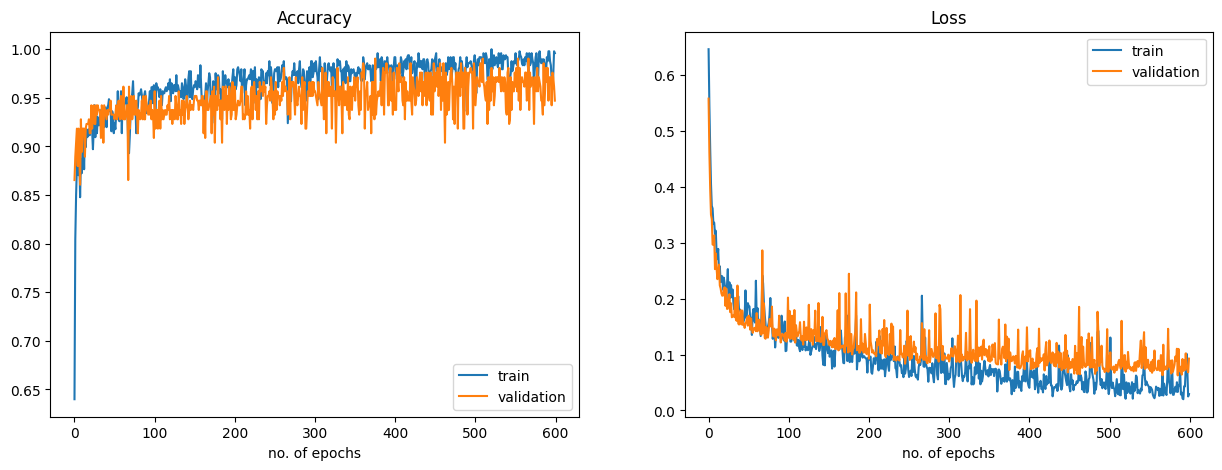


 The best results for few_transformations:


,train,val
loss,0.0382,0.0675
acc,0.9918,0.9856


In [ ]:
model_trained_few, metrics_few, history_few = train_model(dataloaders_few,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_few)

print(f'\n The best results for few_transformations:')
metrics_few

In [ ]:
torch.save(model_trained_few.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt')

###RI_transformations

Epoch 1/500
train loss: 0.3451, train accuracy: 0.8683
val loss: 0.2657, val accuracy: 0.8894
Epoch 2/500
train loss: 0.2385, train accuracy: 0.9136
val loss: 0.3241, val accuracy: 0.8702
Epoch 3/500
train loss: 0.3781, train accuracy: 0.8086
val loss: 0.1675, val accuracy: 0.9423
Epoch 4/500
train loss: 0.1928, train accuracy: 0.9280
val loss: 0.1661, val accuracy: 0.9423
Epoch 5/500
train loss: 0.1819, train accuracy: 0.9239
val loss: 0.1456, val accuracy: 0.9519
Epoch 6/500
train loss: 0.2086, train accuracy: 0.9074
val loss: 0.1449, val accuracy: 0.9375
Epoch 7/500
train loss: 0.1345, train accuracy: 0.9527
val loss: 0.1292, val accuracy: 0.9519
Epoch 8/500
train loss: 0.1559, train accuracy: 0.9383
val loss: 0.1283, val accuracy: 0.9615
Epoch 9/500
train loss: 0.1546, train accuracy: 0.9280
val loss: 0.1232, val accuracy: 0.9567
Epoch 10/500
train loss: 0.1087, train accuracy: 0.9733
val loss: 0.1331, val accuracy: 0.9615
Epoch 11/500
train loss: 0.0997, train accuracy: 0.9691
val

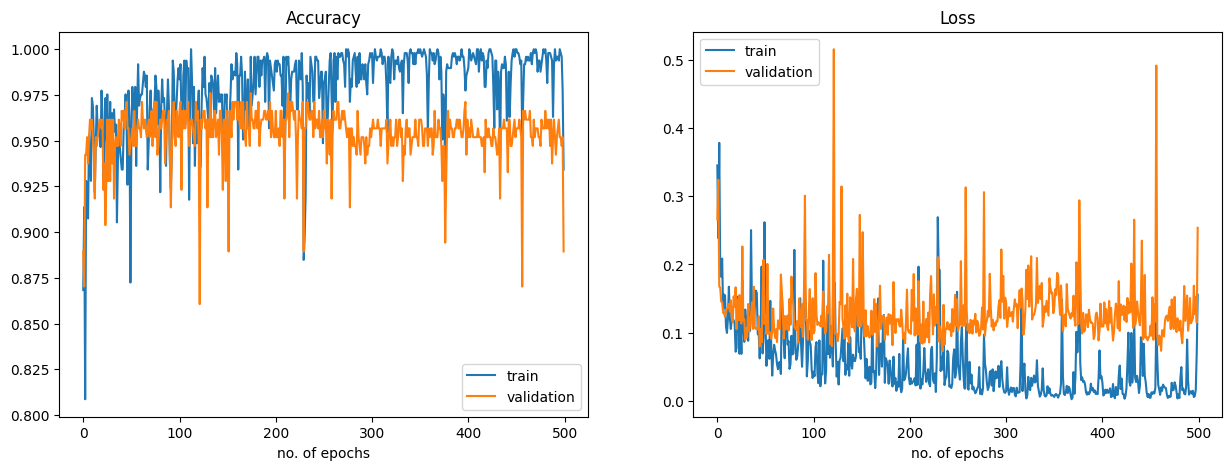


 The best results for ri_transformations:


,train,val
loss,0.0170,0.0986
acc,0.9979,0.9712


In [ ]:
dataloaders_ri = create_dataloaders(transforms.RandomInvert())

model_trained_ri, metrics_ri, history_ri = train_model(dataloaders_ri,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=500)

plot_learning(history_ri)

print(f'\n The best results for ri_transformations:')
metrics_ri

In [ ]:
torch.save(model_trained_ri.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_ri.pt')

###RA_transformation

Epoch 1/400
train loss: 0.5308, train accuracy: 0.7037
val loss: 0.3336, val accuracy: 0.9038
Epoch 2/400
train loss: 0.3168, train accuracy: 0.8642
val loss: 0.2258, val accuracy: 0.9327
Epoch 3/400
train loss: 0.2087, train accuracy: 0.9239
val loss: 0.1864, val accuracy: 0.9279
Epoch 4/400
train loss: 0.1725, train accuracy: 0.9403
val loss: 0.3305, val accuracy: 0.8462
Epoch 5/400
train loss: 0.1741, train accuracy: 0.9300
val loss: 0.2521, val accuracy: 0.8702
Epoch 6/400
train loss: 0.1407, train accuracy: 0.9465
val loss: 0.1490, val accuracy: 0.9375
Epoch 7/400
train loss: 0.1096, train accuracy: 0.9650
val loss: 0.2045, val accuracy: 0.9183
Epoch 8/400
train loss: 0.1221, train accuracy: 0.9403
val loss: 0.1645, val accuracy: 0.9279
Epoch 9/400
train loss: 0.0923, train accuracy: 0.9609
val loss: 0.1382, val accuracy: 0.9423
Epoch 10/400
train loss: 0.2072, train accuracy: 0.9115
val loss: 0.3287, val accuracy: 0.8558
Epoch 11/400
train loss: 0.1000, train accuracy: 0.9691
val

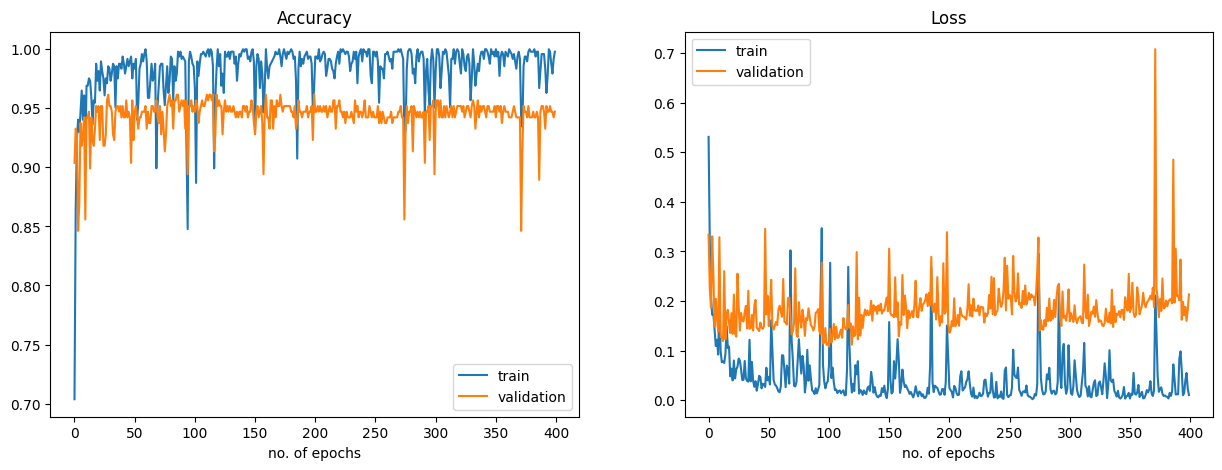


 The best results for ra_transformations:


,train,val
loss,0.0151,0.1577
acc,1.0000,0.9615


In [ ]:
dataloaders_ra = create_dataloaders(transforms.RandomAutocontrast())

model_trained_ra, metrics_ra, history_ra = train_model(dataloaders_ra,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=400)

plot_learning(history_ra)

print(f'\n The best results for ra_transformations:')
metrics_ra

In [ ]:
torch.save(model_trained_ra.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_ra.pt')

###RE_transformations

Epoch 1/400
train loss: 0.5394, train accuracy: 0.7016
val loss: 0.3127, val accuracy: 0.8846
Epoch 2/400
train loss: 0.3441, train accuracy: 0.8498
val loss: 0.2075, val accuracy: 0.9327
Epoch 3/400
train loss: 0.3061, train accuracy: 0.8827
val loss: 0.2161, val accuracy: 0.9087
Epoch 4/400
train loss: 0.1967, train accuracy: 0.9362
val loss: 0.1872, val accuracy: 0.9135
Epoch 5/400
train loss: 0.2040, train accuracy: 0.9300
val loss: 0.1710, val accuracy: 0.9327
Epoch 6/400
train loss: 0.1505, train accuracy: 0.9444
val loss: 0.1458, val accuracy: 0.9423
Epoch 7/400
train loss: 0.1978, train accuracy: 0.9239
val loss: 0.1395, val accuracy: 0.9327
Epoch 8/400
train loss: 0.2179, train accuracy: 0.9198
val loss: 0.1490, val accuracy: 0.9327
Epoch 9/400
train loss: 0.1350, train accuracy: 0.9609
val loss: 0.1324, val accuracy: 0.9471
Epoch 10/400
train loss: 0.2412, train accuracy: 0.9095
val loss: 0.1232, val accuracy: 0.9567
Epoch 11/400
train loss: 0.3269, train accuracy: 0.8519
val

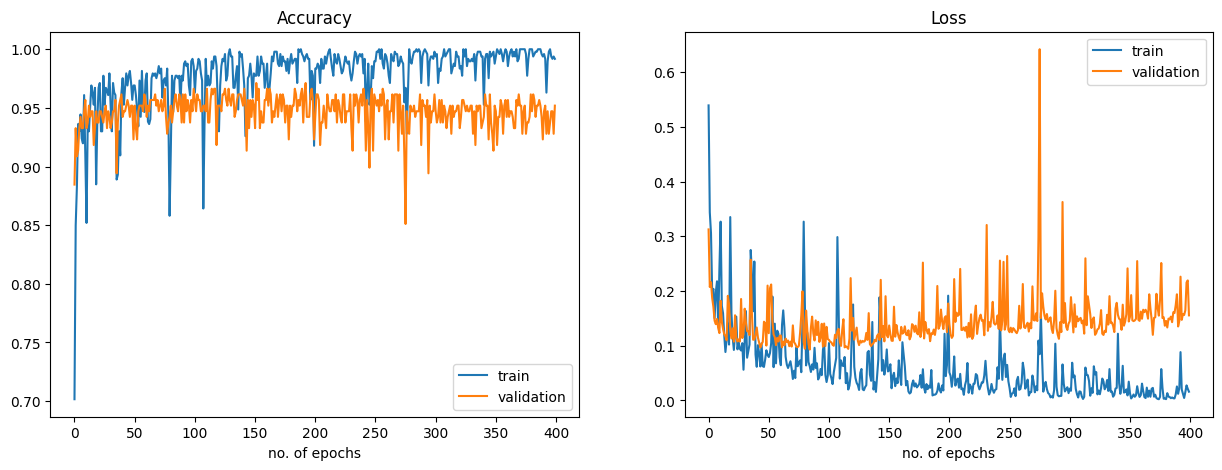


 The best results for re_transformations:


,train,val
loss,0.0121,0.1348
acc,0.9959,0.9663


In [ ]:
dataloaders_re = create_dataloaders(transforms.RandomEqualize())

model_trained_re, metrics_re, history_re = train_model(dataloaders_re,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=400)

plot_learning(history_re)

print(f'\n The best results for re_transformations:')
metrics_re

In [ ]:
torch.save(model_trained_re.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_re.pt')

###TAW_transformations

Epoch 1/600
train loss: 0.7359, train accuracy: 0.5967
val loss: 0.6129, val accuracy: 0.6923
Epoch 2/600
train loss: 0.5575, train accuracy: 0.8272
val loss: 0.4730, val accuracy: 0.8606
Epoch 3/600
train loss: 0.4172, train accuracy: 0.8765
val loss: 0.3305, val accuracy: 0.9038
Epoch 4/600
train loss: 0.3143, train accuracy: 0.9033
val loss: 0.3046, val accuracy: 0.8702
Epoch 5/600
train loss: 0.2977, train accuracy: 0.8683
val loss: 0.2883, val accuracy: 0.8798
Epoch 6/600
train loss: 0.2297, train accuracy: 0.9136
val loss: 0.1917, val accuracy: 0.9231
Epoch 7/600
train loss: 0.2294, train accuracy: 0.9156
val loss: 0.1850, val accuracy: 0.9279
Epoch 8/600
train loss: 0.2238, train accuracy: 0.9012
val loss: 0.2998, val accuracy: 0.8510
Epoch 9/600
train loss: 0.2514, train accuracy: 0.8951
val loss: 0.2302, val accuracy: 0.9087
Epoch 10/600
train loss: 0.2518, train accuracy: 0.9053
val loss: 0.1591, val accuracy: 0.9375
Epoch 11/600
train loss: 0.1568, train accuracy: 0.9527
val

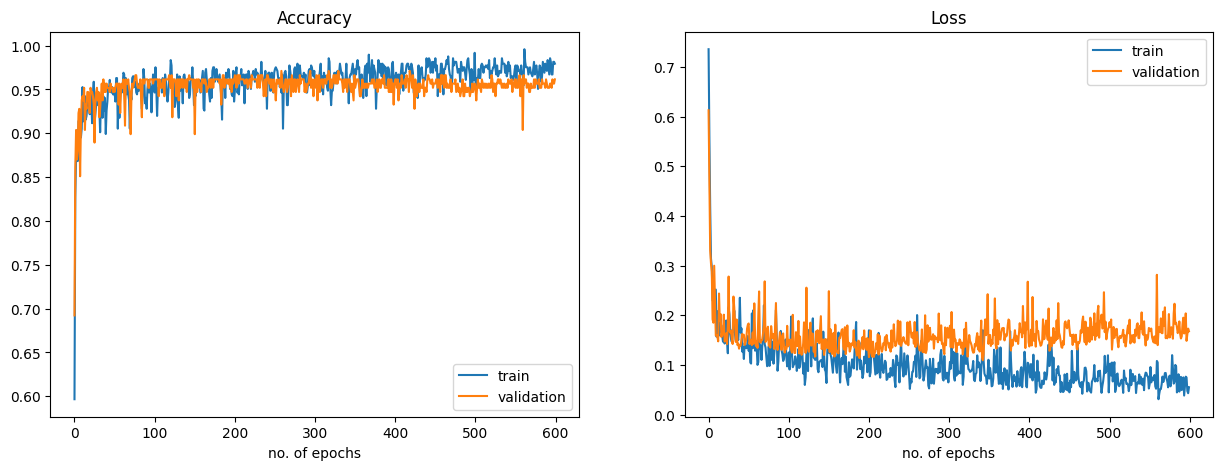


 The best results for taw_transformations:


,train,val
loss,0.0598,0.1215
acc,0.9856,0.9712


In [ ]:
dataloaders_taw = create_dataloaders(transforms.TrivialAugmentWide())

model_trained_taw, metrics_taw, history_taw = train_model(dataloaders_taw,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_taw)

print(f'\n The best results for taw_transformations:')
metrics_taw

In [ ]:
torch.save(model_trained_taw.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_taw.pt')

###AutoA_transformations

Epoch 1/600
train loss: 0.8405, train accuracy: 0.5206
val loss: 0.6274, val accuracy: 0.7452
Epoch 2/600
train loss: 0.6203, train accuracy: 0.7346
val loss: 0.5391, val accuracy: 0.8462
Epoch 3/600
train loss: 0.5089, train accuracy: 0.8292
val loss: 0.4301, val accuracy: 0.9087
Epoch 4/600
train loss: 0.4464, train accuracy: 0.8292
val loss: 0.3364, val accuracy: 0.9038
Epoch 5/600
train loss: 0.3942, train accuracy: 0.8498
val loss: 0.2758, val accuracy: 0.9279
Epoch 6/600
train loss: 0.3533, train accuracy: 0.8642
val loss: 0.2732, val accuracy: 0.9038
Epoch 7/600
train loss: 0.2673, train accuracy: 0.9218
val loss: 0.2368, val accuracy: 0.9183
Epoch 8/600
train loss: 0.2869, train accuracy: 0.8827
val loss: 0.2082, val accuracy: 0.9279
Epoch 9/600
train loss: 0.2933, train accuracy: 0.8992
val loss: 0.1919, val accuracy: 0.9423
Epoch 10/600
train loss: 0.2278, train accuracy: 0.9156
val loss: 0.3194, val accuracy: 0.8558
Epoch 11/600
train loss: 0.3284, train accuracy: 0.8519
val

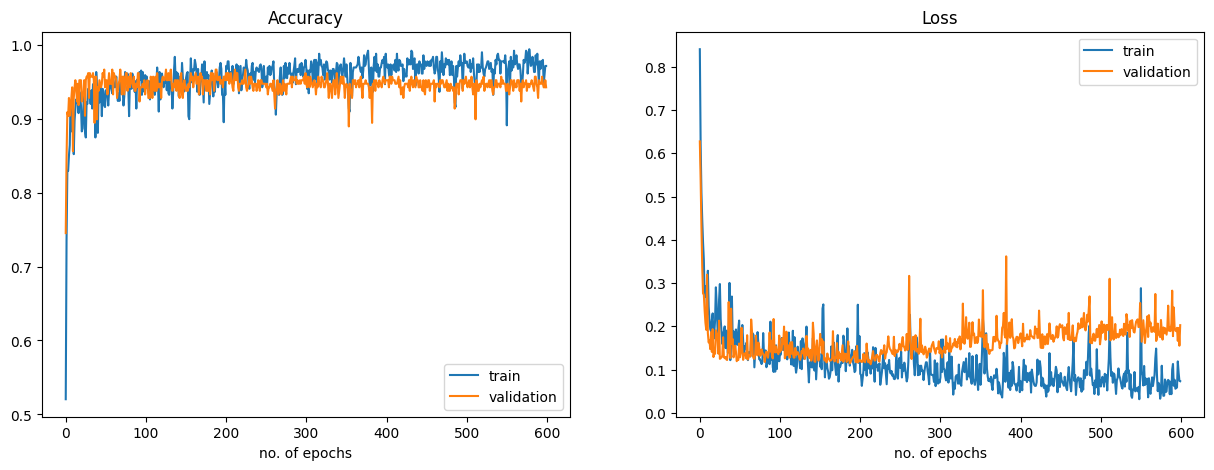


 The best results for aa_transformations:


,train,val
loss,0.1142,0.1186
acc,0.9630,0.9663


In [ ]:
dataloaders_aa = create_dataloaders(transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET))

model_trained_aa, metrics_aa, history_aa = train_model(dataloaders_aa,
                                                          model,
                                                          criterion,
                                                          optimizer,
                                                          num_epochs=600)

plot_learning(history_aa)

print(f'\n The best results for aa_transformations:')
metrics_aa

In [ ]:
torch.save(model_trained_aa.state_dict(),'/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_aa.pt')

##Evaluate

In [ ]:
outcomes = pd.concat([metrics_few, metrics_ri, metrics_ra, metrics_re, metrics_taw, metrics_aa],
                     keys=['few_transformation', 'RI_transformation', 'RA_transformation', 'RE_transformation', 'TAW_transformation', 'AutoA_transformation'])
outcomes

train     val
few_transformation   loss  0.0382  0.0675
                     acc   0.9918  0.9856
RI_transformation    loss  0.0170  0.0986
                     acc   0.9979  0.9712
RA_transformation    loss  0.0151  0.1577
                     acc   1.0000  0.9615
RE_transformation    loss  0.0121  0.1348
                     acc   0.9959  0.9663
TAW_transformation   loss  0.0351  0.1554
                     acc   0.9877  0.9615
AutoA_transformation loss  0.1142  0.1186
                     acc   0.9630  0.9663

##Loading model

##Prediction

In [ ]:
dataloaders = dataloaders_few
best_model = model
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/Alien_vs_Predator/best_model_few.pt'))
loss, accuracy = test_model(dataloaders['test'], best_model, criterion)
print(f'Accuracy for test dataset: {accuracy:.4f}')
print(f'Loss for test dataset: {loss:.4f}')

Accuracy for test dataset: 0.9400
Loss for test dataset: 0.1772


###Sample preditions

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(), normalize])

In [ ]:
img_label_list = [rand_image('test') for i in range(4)]
img_list = [img_label_list[i][0] for i in range(4)]
label_list = [img_label_list[i][1] for i in range(4)]

In [ ]:
test_batch = torch.stack([data_transforms(img).to(device) for img in img_list])

pred_logits_tensor = best_model(test_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()*100

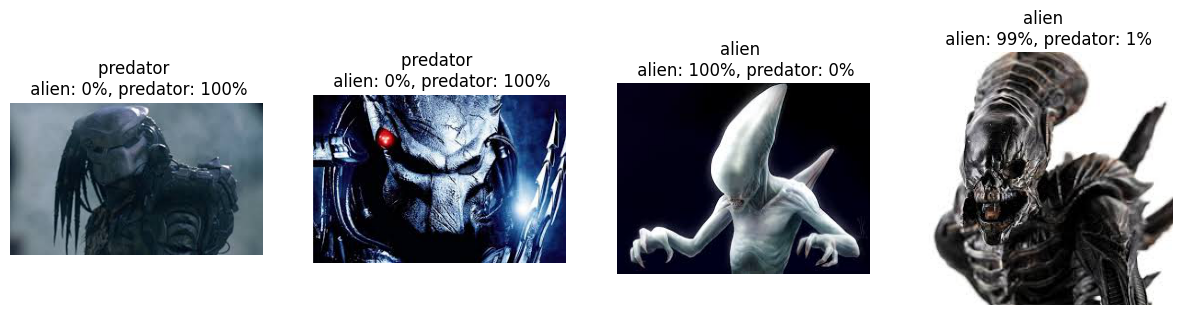

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))

for i, img in enumerate(img_list):
  ax = axs[i]
  ax.axis('off')
  ax.set_title(f'{label_list[i]} \n alien: {pred_probs[i,0]:.0f}%, predator: {pred_probs[i,1]:.0f}%')
  ax.imshow(img)